# Técnicas de Machine Learning para Classificação Supervisionada de Contas Bots do Twitter.

## FIA LABDATA - Turma 13

### Fabio Daleffi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [2]:
df_original = pd.read_csv('classified_twitter_accounts.csv')

In [3]:
df_original.columns

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'lang',
       'default_profile', 'default_profile_image', 'geo_enabled', 'protected',
       'verified', 'classification', 'dataset', 'screen_name_total_len',
       'screen_name_num_len', 'name_total_len', 'name_num_len', 'is_url_null',
       'is_location_null', 'profile_banner_url_null', 'profile_image_url_null',
       'description_null'],
      dtype='object')

In [4]:
df_original.shape

(14368, 25)

In [5]:
# DROP FEATURES LIST

#ALTA CARDINALIDADE
alta_card = ['id','name', 'screen_name']

# ALTA CORRELACAO (IDENTIFICADA NA ANALISE EXPLORATORIA)
correlacao = ['listed_count']

construidas = [
    'screen_name_total_len',  
    'screen_name_num_len',       
    'name_total_len',            
    'name_num_len',              
    'is_url_null',               
    'is_location_null',          
    'profile_banner_url_null',   
    'profile_image_url_null',    
    'description_null'
] 


drop_features = alta_card + correlacao + construidas

# VARIAVEIS DE CONTROLE DO DATASET
drop_features.append('dataset')

df_accounts = df_original.drop(drop_features, axis=1)

In [6]:
# target
df_accounts['target'] = np.where(df_accounts.classification == "bot", 1, 0)
df_accounts.drop('classification', axis=1, inplace=True)

In [7]:
df_accounts.dtypes

statuses_count            int64
followers_count           int64
friends_count             int64
favourites_count          int64
lang                     object
default_profile            bool
default_profile_image      bool
geo_enabled                bool
protected                  bool
verified                   bool
target                    int32
dtype: object

In [8]:
df_accounts.shape

(14368, 11)

In [9]:
df_accounts.describe()

,statuses_count,followers_count,friends_count,favourites_count,target
count,14368.000000,1.436800e+04,14368.000000,14368.000000,14368.000000
mean,5063.190910,8.682774e+02,589.318834,1145.288280,0.758213
std,17493.409898,2.688472e+04,2665.832959,6036.894173,0.428181
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,31.000000,6.000000e+00,42.000000,0.000000,1.000000
50%,63.000000,2.500000e+01,250.000000,0.000000,1.000000
75%,1365.250000,3.320000e+02,538.000000,9.000000,1.000000
max,399555.000000,2.991573e+06,211890.000000,313954.000000,1.000000


# CATEGORIZANDO AS VARIÁVEIS

In [10]:
df = df_accounts.copy()

In [11]:
df['statuses_count'] = pd.cut(df.statuses_count, bins=[-1,31,63,1365,399555], labels=[
     '1 - DE 0 ATE 31'
    ,'2 - DE 32 ATE 63'
    ,'3 - DE 64 ATE 1365'
    ,'4 - ACIMA DE 1365'
] )

In [12]:
df['followers_count'] = pd.cut(df.followers_count, bins=[-1,6,25,332,2991573], labels=[
     '1 - DE 0 ATE 6'
    ,'2 - DE 7 ATE 25'
    ,'3 - DE 26 ATE 332'
    ,'4 - ACIMA DE 332'
] )

In [13]:
df['friends_count'] = pd.cut(df.friends_count, bins=[-1,42,250,538,211890], labels=[
     '1 - DE 0 ATE 42'
    ,'2 - DE 43 ATE 250'
    ,'3 - DE 251 ATE 538'
    ,'4 - ACIMA DE 538'
])

In [14]:
df['favourites_count'] = pd.cut(df.favourites_count, bins=[-1,9,313954], labels=[
     '1 - DE 0 ATE 9'
    ,'2 - ACIMA DE 9'
])

In [15]:
df['lang'] = np.where(df.lang == "en", 'ENGLISH', 'OTHERS')
df['lang'] = df['lang'].astype('category')

# Criar Dummies

In [16]:
cat_vars = df.drop('target', axis=1).columns

for var in cat_vars:

    cat_list='var' +'_'+ var
    cat_list = pd.get_dummies(df[var], prefix = var, drop_first=True)
    df=df.join(cat_list)

df.drop(cat_vars, axis = 1, inplace = True)

# Machine Learning - Comparando Diferentes Modelos

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate
from tqdm import tqdm

In [19]:
models = [('Random Forest', RandomForestClassifier(n_estimators=500, min_samples_split=5)),
          ('Gradient Boost', GradientBoostingClassifier(n_estimators=1000, min_samples_split=5)),
          ('XGBoosting', XGBClassifier(n_estimators=1000, min_samples_split=5)),
          ('Catboost', CatBoostClassifier(n_estimators=1000, verbose=False))
         ]

In [20]:
def compare_models(models_list=models, sort_by='accuracy', folds=5):

    comparison_table = pd.DataFrame(columns=['model', 'mean_accuracy', 'std_accuracy', 'mean_roc_auc', 'std_roc_auc'])

    for model in tqdm(models):
        cv_results = cross_validate(model[1], X_train, y_train, cv=folds, scoring=['roc_auc', 'accuracy'])

        model_results = pd.DataFrame({
            'model': [model[0]],
            'mean_accuracy': [cv_results['test_accuracy'].mean()],
            'std_accuracy': [cv_results['test_accuracy'].std()],
            'mean_roc_auc': [cv_results['test_roc_auc'].mean()],
            'std_roc_auc': [cv_results['test_roc_auc'].std()]
        })

        comparison_table = pd.concat([comparison_table, model_results], axis=0)
        
    return comparison_table.sort_values(by=['mean_' + sort_by], ascending=False).reset_index(drop=True)

In [144]:
compare_models()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:38<00:00, 24.51s/it]


,model,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc
0,XGBoosting,0.978920,0.003094,0.991244,0.001762
1,Random Forest,0.978820,0.003513,0.991829,0.001116
2,Gradient Boost,0.978721,0.002363,0.992537,0.000760
3,Catboost,0.978721,0.002993,0.993725,0.001276


#### Extreme Gradient Boosting foi o modelo com melhor acurácia.

In [21]:
xgb = XGBClassifier(n_estimators=1000, min_samples_split=5)

xgb.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predictions = xgb.predict(X_test)
accuracy_score(y_test, y_predictions)

0.9768035258640687

## Tunning de hiperparâmetros do melhor Modelo - Grid Search

In [22]:
xgb = XGBClassifier(n_estimators=1000, min_samples_split=5)

model_pipe = [('XGB', xgb)]

In [23]:
from sklearn.model_selection import GridSearchCV

parameters_distributions = {'XGB__learning_rate': [0.001, 0.01, 0.1], 
                            'XGB__subsample': [0.5, 1.0],
                            'XGB__n_estimators': [500, 1000, 5000],
                            'XGB__min_samples_split': [2, 5, 7],
                            'XGB__max_depth': [3, 5, 7]}

grid_search = GridSearchCV((model_pipe[0])[1], parameters_distributions, scoring='accuracy', 
                           cv=5, n_jobs=-1)

In [173]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     min_samples_split=5, missing=nan,
                                     monotone_cons...
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'XGB__learning_rate': [0.00

# Melhor Modelo

### Acurácia Teste:

In [174]:
best_model_xgb = grid_search.best_estimator_

y_predictions = best_model_xgb.predict(X_test)
accuracy_score(y_test, y_predictions)

0.9768035258640687

### Parâmetros

In [176]:
best_model_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 1000,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'min_samples_split': 5,
 'XGB__learning_rate': 0.001,
 'XGB__max_depth': 3,
 'XGB__min_samples_split': 2,
 'XGB__n_estimators': 500,
 'XGB__subsample': 0.5}

In [26]:
xgb_bestmodel = XGBClassifier(n_estimators=500, min_samples_split=2, subsample = 0.5, learning_rate = 0.001, max_depth = 3)

In [31]:
xgb_bestmodel.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predictions = xgb_bestmodel.predict(X_test)
accuracy_score(y_test, y_predictions)

0.9705404778473672

In [35]:
xgb_bestmodel.feature_importances_

array([5.9290826e-03, 1.2230569e-03, 1.6108698e-03, 4.3141595e-03,
       3.1877041e-04, 1.8806799e-03, 1.8298288e-03, 3.0058068e-03,
       4.5589064e-03, 9.6323204e-01, 3.6671853e-03, 2.6838451e-03,
       5.6183839e-04, 5.1837973e-03, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

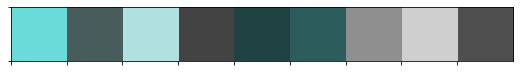

In [46]:
# configurando paleta de cores identidade visual FIA
palette = ['#6ADBD9','#485C5B','#B0E1E0', '#434343','#204242','#2C5C5B', '#8F8F8F', '#CFCFCF','#4F4F4F']

sns.set_palette(palette)

current_palette = sns.color_palette()
sns.palplot(current_palette)

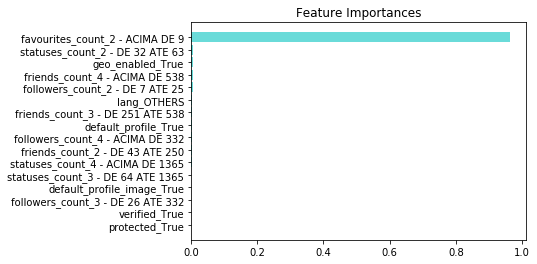

In [50]:
sorted_idx = xgb_bestmodel.feature_importances_.argsort()

plt.barh(X_test.columns[sorted_idx], xgb_bestmodel.feature_importances_[sorted_idx]);
plt.title('Feature Importances');